In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/benedetti/miniconda3/envs/myenc/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/benedetti/miniconda3/envs/myenc/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/benedetti/miniconda3/envs/myenc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) compute standard error on gamma
    #   residual variance σ² = SSR / (n−2)
    y_fit = gamma*logx + logk
    resid = logy - y_fit
    ssr = np.sum(resid**2)
    sigma2 = ssr / (n - 2)
    #   Sxx = Σ (logx − mean(logx))²
    Sxx = np.sum((logx - logx.mean())**2)
    stderr_gamma = np.sqrt(sigma2 / Sxx)

    # 3) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit: γ={gamma:.3f}±{stderr_gamma:.3f}", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma, stderr_gamma

In [3]:
def fit_phi(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * xs**(-gamma_i)
        plt.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_and_plot_powerlaw_offset(x, y, C2, ax=None, data_kwargs=None, fit_kwargs=None):
    """
    Fit y = k * x**gamma + C to data (x,y),
    plot both the raw data and the fit on log–log axes (for x and y–C),
    and return (k, gamma, C).

    Parameters
    ----------
    x : array-like, shape (n,)
        Independent variable (must be > 0).
    y : array-like, shape (n,)
        Dependent variable (must be > 0).
    ax : matplotlib Axes, optional
        If given, plot onto this axes; otherwise uses current axes.
    data_kwargs : dict, optional
        kwargs passed to ax.plot for the data.
    fit_kwargs : dict, optional
        kwargs passed to ax.plot for the fitted curve.

    Returns
    -------
    k : float
        Fitted coefficient.
    gamma : float
        Fitted exponent.
    C : float
        Fitted additive offset.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # 1) define the model
    def model(x, k, gamma):
        return k * x**gamma - C2

    # 2) initial guess: use no‐offset log‐log fit to estimate k,gamma, and C≈min(y)/10
    logx = np.log(x)
    logy = np.log(y)
    gamma0, logk0 = np.polyfit(logx, logy, 1)
    k0 = np.exp(logk0)
    #C0 = np.min(y) * 0.1
    p0 = [k0, gamma0]

    # 3) perform the non-linear fit
    popt, pcov = curve_fit(model, x, y, p0=p0, maxfev=10000)
    k, gamma = popt

    # 4) plotting
    if ax is None:
        ax = plt.gca()
    data_kwargs = {} if data_kwargs is None else data_kwargs
    fit_kwargs = {"linestyle":"--", "linewidth":2} if fit_kwargs is None else fit_kwargs

    # raw data
    ax.plot(x, y, label="data", **data_kwargs)
    # fitted curve
    ax.plot(x, model(x, k, gamma),
            label=(f"fit: $k={k:.2g},\\gamma={gamma:.2g},C={C2:.2g}$"),
            **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma


# ResNet MNIST

/tmp/ipykernel_28265/3642088708.py:42: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


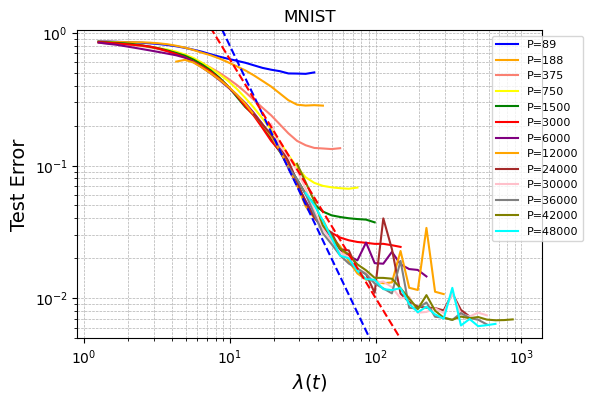

In [5]:
dataset="MNIST"
P_arr = np.array([89, 188, 375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000])
#seed_arr = np.arange(1140,1170,1)
seed_arr = np.arange(1140,1169,1)

# Store interpolated results here
mean_curves = {}
colorlist   = np.array(["blue","orange","salmon","yellow","green","red","purple","orange","brown","pink","grey","olive","cyan"])
l_0_arr = np.zeros(len(P_arr))

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 3, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    wd=0.
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/ResNet_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error = np.array(logs_saved["val_error"])*0.01


        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error
    mean_curves[P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}",  color=colorlist[i_P])

    #####################
    '''
    wd=0.0001
    interpolated_val_errors = []

    for seed in seed_arr:
        logs_saved = np.load(f"./savings/ResNet_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error = np.array(logs_saved["val_error"])*0.01


        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, "--", label=f"P={P}, wd",  color=colorlist[i_P])
    '''
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.1,1.),fontsize=8)
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


gamma_1_a = 2.3
k1_a = 160.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 1.8
k1_b = 40.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.ylim((5e-3,1.05))
#plt.xlim((1e3,1e7))
plt.show()

In [6]:
C2 = 2e1

/tmp/ipykernel_28265/691995466.py:27: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


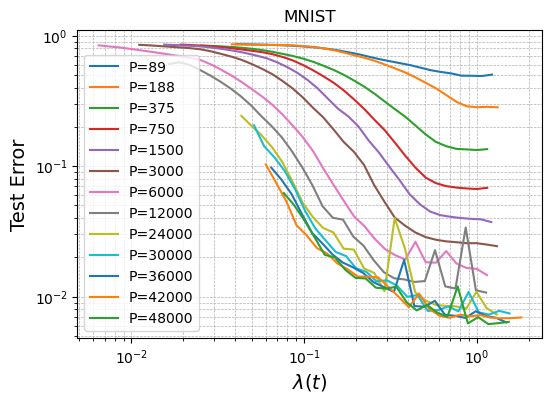

In [7]:
# Store interpolated results here

l_0_arr = np.zeros(len(P_arr))

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/ResNet_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error = np.array(logs_saved["val_error"])*0.01
        l_0 = model_norm[np.argmin((val_error)**2)]/(len(seed_arr))
        l_0_arr[i_P] += l_0

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    # Plot the mean curve
    plt.plot(log_x_grid/l_0_arr[i_P], mean_val_error, label=f"P={P}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

/tmp/ipykernel_28265/1500121039.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


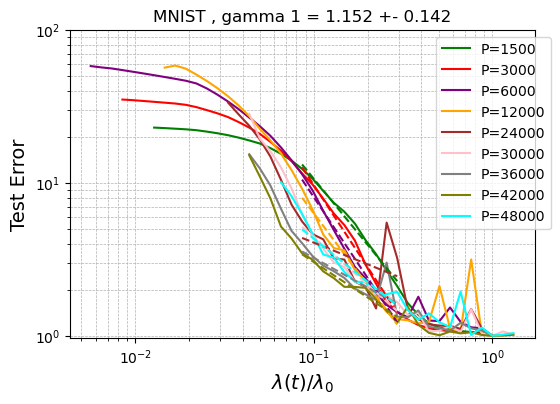

In [17]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/ResNet_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 8e-2
x_right = 3e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,100))
plt.show()

In [18]:
factor = 1

Fitted power law: k2 = 2.299, gamma2 = 0.4951


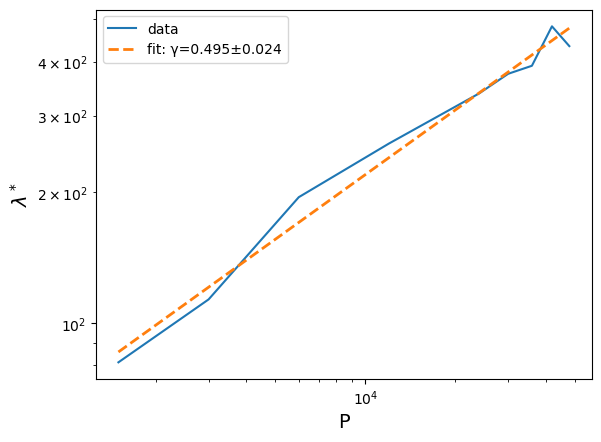

In [19]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [21]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

'\nl_power_law = factor * l_0_arr\n\nk2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)\nprint(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")\n'

0.9394768003850418


/tmp/ipykernel_28265/1926827386.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


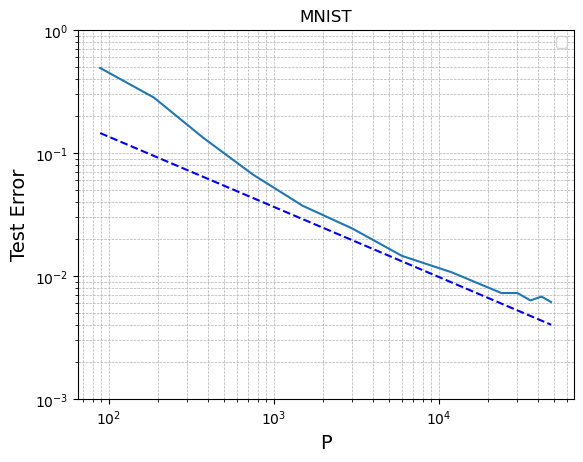

In [21]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)
plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-3,1.01))
plt.show()

In [22]:
to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

In [23]:
name_save = "analysis/ResNet_MNIST"

np.save(name_save, to_save)

# CNN MNIST

/tmp/ipykernel_28265/3855879867.py:40: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


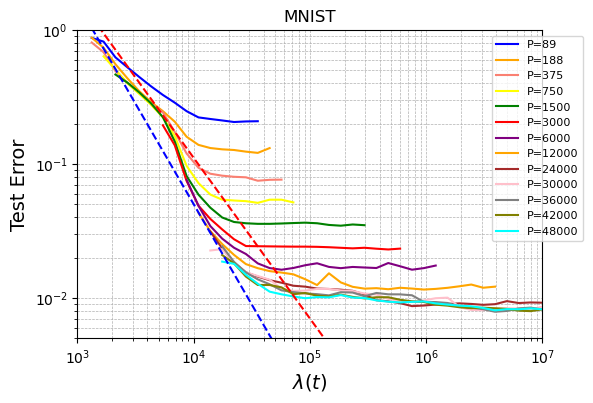

In [25]:
dataset="MNIST"
P_arr = np.array([89, 188, 375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000])
seed_arr = np.arange(1140,1162,1)

# Store interpolated results here
mean_curves = {}
colorlist   = np.array(["blue","orange","salmon","yellow","green","red","purple","orange","brown","pink","grey","olive","cyan"])
l_0_arr = np.zeros(len(P_arr))
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2, 7, num=50)  # Adjust range and number of points as needed

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    wd=0.
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/CNN_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}",  color=colorlist[i_P])



plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.1,1.),fontsize=8)
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


gamma_1_a = 1.5
k1_a = 50000.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 1.2
k1_b = 7000.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.ylim((5e-3,1.))
plt.xlim((1e3,1e7))
plt.show()

In [26]:
C2 = 2e3

/tmp/ipykernel_28265/2980861677.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


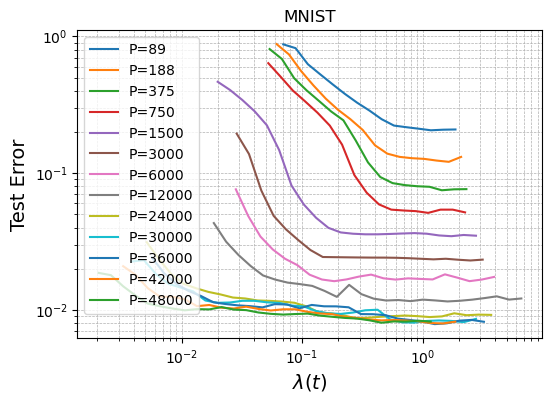

In [27]:
# Store interpolated results here

l_0_arr = np.zeros(len(P_arr))

# Generate a common log-space grid for interpolation


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/CNN_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error = np.array(logs_saved["val_error"])*0.01
        l_0 = model_norm[np.argmin((val_error)**2)]/(len(seed_arr))
        l_0_arr[i_P] += l_0

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    # Plot the mean curve
    plt.plot(log_x_grid/l_0_arr[i_P], mean_val_error, label=f"P={P}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

/tmp/ipykernel_28265/3146023586.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


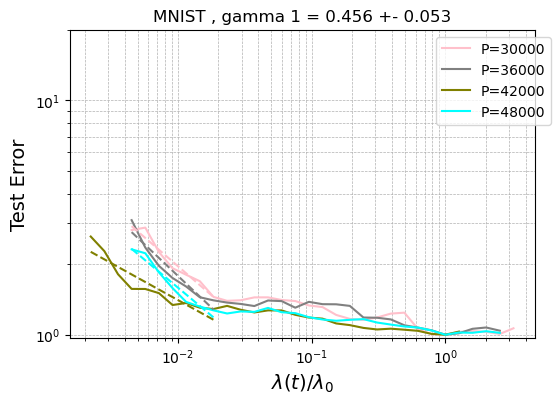

In [41]:
# Store interpolated results here
min_P = 9
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"./savings/CNN_{dataset}_P{P}_seed{seed}_wd{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 2e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,20))
plt.show()

In [42]:
factor = 1

Fitted power law: k2 = 0.006353, gamma2 = 1.936


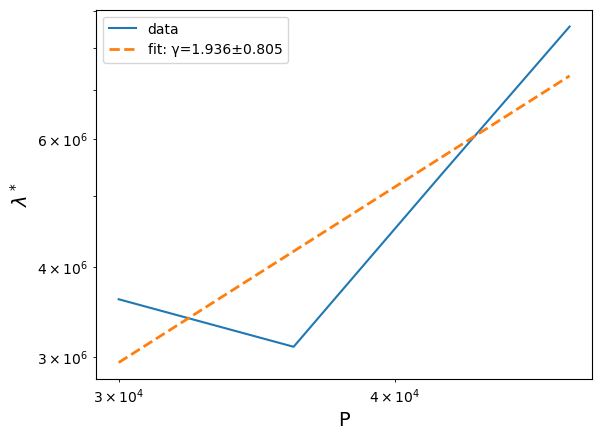

In [43]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [60]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

'\nl_power_law = factor * l_0_arr\n\nk2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)\nprint(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")\n'

1.0832463652669948


/tmp/ipykernel_28265/3108018153.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


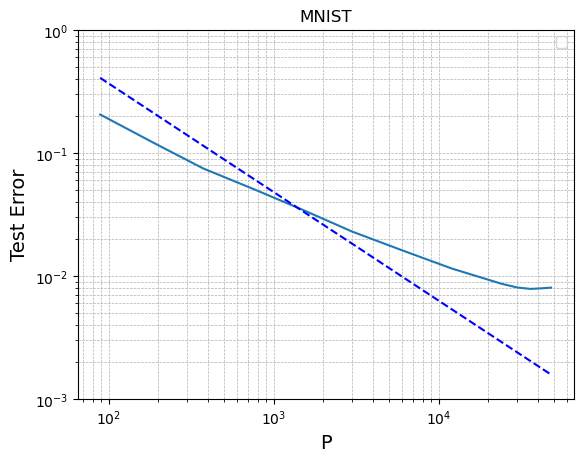

In [44]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-3,1.01))
plt.show()

In [45]:
name_save = "analysis/CNN_MNIST"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)